In [4]:
from ..server.rb87_mot_model.py import plot_results

ImportError: attempted relative import with no known parent package

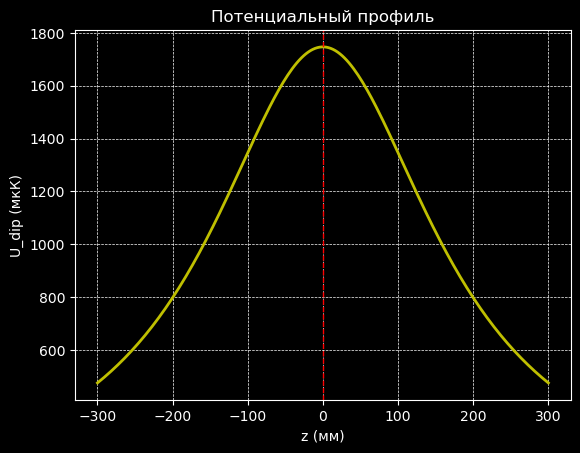

In [42]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Исходные параметры
s = 1231  # mm
W_0 = 243 * 10**(-3)  # mm
z_R = math.pi * (W_0**2) / (1012 * 10**(-6))  # mm
w_0 = 296 * 10**(12)  # Hz
delta = 88 * 10**(12)  # Hz
Gamma = 3 * 10**6  # Hz
f = 50  # mm
P = 2  # W

# Рассчитываем новые параметры
W_0_new = W_0 * (f / (((s - f)**2 + z_R**2) ** 0.5))  # mm

# Функция потенциала
def U_dip(r, z):
    W = W_0_new * np.sqrt(1 + (z / z_R)**2)
    I = (2 * P / (math.pi * (W * 10**(-3))**2)) * np.exp((-2 * r**2) / ((W * 10**(-3))**2))
    U = ((3 * math.pi * (3 * 10**8)**2) / (2 * w_0**3)) * Gamma * ((1 / delta) - (1 / (2 * w_0 + delta))) * I / ((2 * math.pi)**3)
    return U / (1.38 * 10**(-23) * 10**(-6))

# Диапазон для z
z = np.linspace(-300, 300, 200)
U_values = np.array([U_dip(0, zi) for zi in z])

# Построение графика
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.set_xlabel('z (мм)')
ax.set_ylabel('U_dip (мкК)')
ax.set_title('Потенциальный профиль')

ax.plot(z, U_values, color='y', lw=2)
ax.axvline(0, color='r', linestyle='--', lw=1)  # Вертикальная линия в нуле
ax.grid(True, linestyle='--', linewidth=0.5)

plt.show()

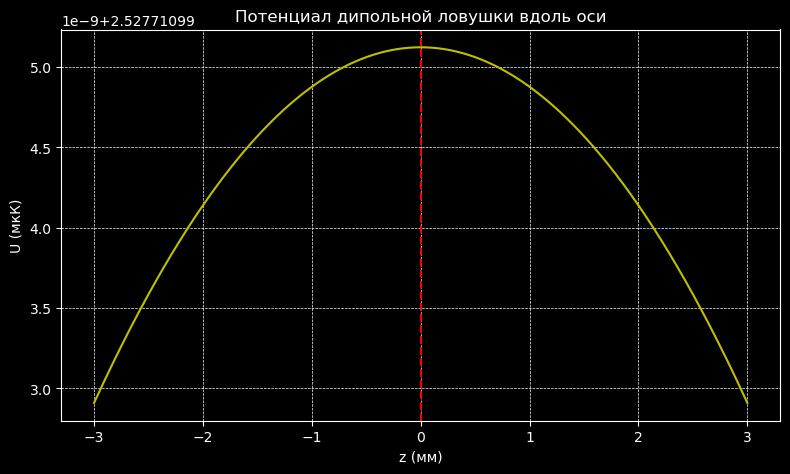

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Константы ---
c = 3e8  # скорость света, м/с
hbar = 1.055e-34  # Дж·с
k_B = 1.38e-23  # Дж/К
lambda_trap = 1012e-9  # длина волны ловушки, м
omega = 2 * np.pi * c / lambda_trap  # частота ловушки, рад/с
omega_0 = 2 * np.pi * 296e12  # частота перехода, рад/с
delta = omega - omega_0  # детюнинг (с учётом знака)
Gamma = 2 * np.pi * 6e6  # частота затухания
P = 2  # мощность, Вт
w_0 = 243e-6  # минимальный радиус пучка (до линзы), м

# --- Расчёт параметров пучка ---
z_R = np.pi * w_0**2 / lambda_trap  # длина Релея
s = 1231e-3  # расстояние от источника до линзы, м
f = 50e-3  # фокусное расстояние линзы, м

# АБЦД-матрица линзы и пространства
z = s - f
M = np.array([[1, z], [0, 1]]) @ np.array([[1, 0], [-1/f, 1]])
q_in = 1j * z_R
q_out = (M[0,0]*q_in + M[0,1]) / (M[1,0]*q_in + M[1,1])
w_0_new = np.sqrt(-lambda_trap / (np.pi * np.imag(1/q_out)))  # новый w0 после линзы
z_R_new = np.pi * w_0_new**2 / lambda_trap

# --- Потенциал дипольной ловушки ---
def intensity(r, z):
    w_z = w_0_new * np.sqrt(1 + (z / z_R_new)**2)
    return 2 * P / (np.pi * w_z**2) * np.exp(-2 * r**2 / w_z**2)

def U_dip(r, z):
    I = intensity(r, z)
    prefactor = (3 * np.pi * c**2 * Gamma) / (2 * omega_0**3)
    U = prefactor * (1 / delta + 1 / (omega + delta)) * I
    return U / (k_B * 1e-6)  # мкК

# --- Визуализация ---
z_vals = np.linspace(-0.003, 0.003, 500)  # 6 мм диапазон
U_vals = [U_dip(0, z) for z in z_vals]

plt.style.use('dark_background')
plt.figure(figsize=(8,5))
plt.plot(z_vals * 1e3, U_vals, color='y')
plt.xlabel('z (мм)')
plt.ylabel('U (мкК)')
plt.title('Потенциал дипольной ловушки вдоль оси')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axvline(0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

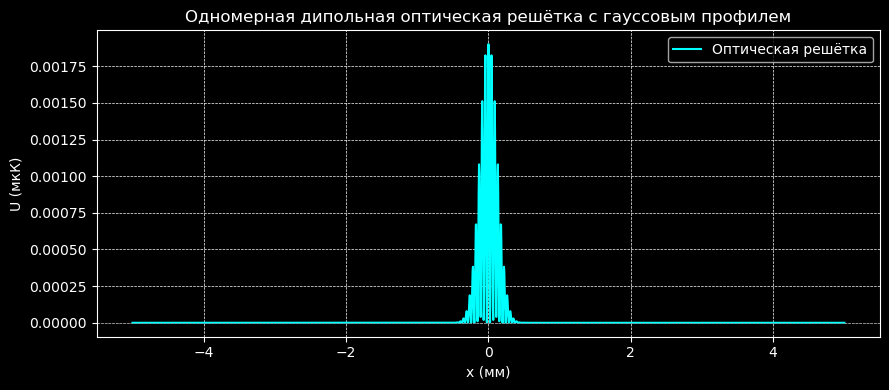

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Физические константы
c = 3e8  # скорость света, м/с
hbar = 1.0545718e-34  # Дж·с
k_B = 1.38e-23  # Дж/К

# Параметры ловушки и лазера
lambda_laser = 1012e-9  # м
w_0 = 243e-6  # радиус пучка в центре, м
P = 2  # мощность лазера, Вт
Gamma = 3e6  # Γ, Гц
omega_0 = 2 * np.pi * 296e12  # резонансная частота Rb-87
delta = 2 * np.pi * 88e12  # детюнинг, Гц

# Волновой вектор
k_laser = 2 * np.pi / lambda_laser

# Функция распределения интенсивности в 1D интерференционной решетке (с гауссовой огибающей)
def I_lattice(x):
    envelope = np.exp(-2 * x**2 / w_0**2)
    standing_wave = np.cos(k_laser * x)**2
    return (2 * P / (np.pi * w_0**2)) * envelope * standing_wave

# Потенциал дипольной решётки
def U_lattice(x):
    I = I_lattice(x)
    prefactor = (3 * np.pi * c**2) / (2 * omega_0**3)
    U = prefactor * Gamma * ((1 / delta) - (1 / (2 * omega_0 + delta))) * I / (2 * np.pi)**3
    return U / (k_B * 1e-6)  # переводим в мкК

# Расчёт
x = np.linspace(-5e-3, 5e-3, 2000)  # от -5 до 5 мм
U = U_lattice(x)

# Построение графика
plt.style.use("dark_background")
plt.figure(figsize=(9, 4))
plt.plot(x * 1e3, U, color='cyan', label='Оптическая решётка')
plt.xlabel("x (мм)")
plt.ylabel("U (мкК)")
plt.title("Одномерная дипольная оптическая решётка с гауссовым профилем")
plt.axhline(0, color='gray', lw=0.5, ls="--")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

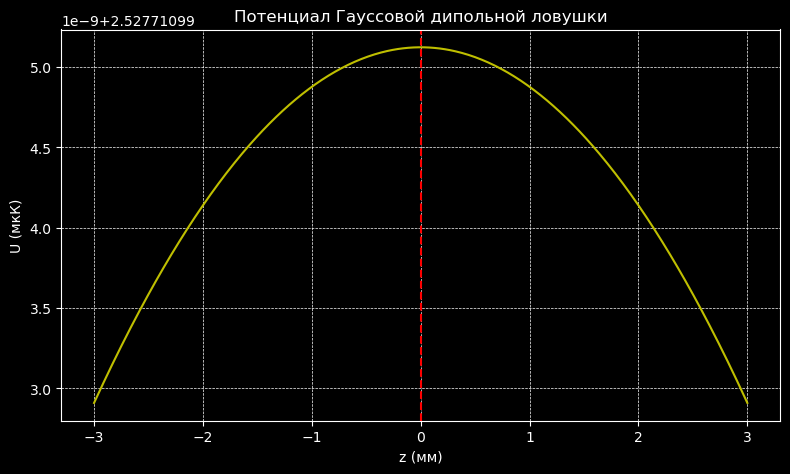

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Константы ---
c = 3e8  # м/с
hbar = 1.055e-34  # Дж·с
k_B = 1.38e-23  # Дж/К
lambda_laser = 1012e-9  # м
omega = 2 * np.pi * c / lambda_laser
omega_0 = 2 * np.pi * 296e12
delta = omega - omega_0
Gamma = 2 * np.pi * 6e6  # рад/с
P = 2  # Вт
w_0_input = 243e-6  # м

# --- Параметры фокусировки ---
s = 1231e-3  # расстояние от источника до линзы, м
f = 50e-3  # фокусное расстояние, м
z = s - f

# ABCD-матрица
z_R = np.pi * w_0_input**2 / lambda_laser
M = np.array([[1, z], [0, 1]]) @ np.array([[1, 0], [-1/f, 1]])
q_in = 1j * z_R
q_out = (M[0,0]*q_in + M[0,1]) / (M[1,0]*q_in + M[1,1])
w_0 = np.sqrt(-lambda_laser / (np.pi * np.imag(1/q_out)))
z_R = np.pi * w_0**2 / lambda_laser

# --- Потенциал ---
def I_gauss(r: float, z: float) -> float:
    w_z = w_0 * np.sqrt(1 + (z / z_R)**2)
    return (2 * P / (np.pi * w_z**2)) * np.exp(-2 * r**2 / w_z**2)

def U_gauss(x):
    r = 0  # нас интересует ось, т.е. r = 0
    z = x  # явно обозначаем, что x — это продольная координата
    I = I_gauss(r, z)
    prefactor = (3 * np.pi * c**2 * Gamma) / (2 * omega_0**3)
    U = prefactor * (1 / delta + 1 / (omega + delta)) * I
    return U / (k_B * 1e-6)  # мкК

# --- Визуализация (опц.) ---
if __name__ == "__main__":
    z_vals = np.linspace(-3e-3, 3e-3, 500)
    U_vals = [U_gauss(z) for z in z_vals]

    plt.style.use('dark_background')
    plt.figure(figsize=(8, 5))
    plt.plot(z_vals * 1e3, U_vals, color='y')
    plt.xlabel('z (мм)')
    plt.ylabel('U (мкК)')
    plt.title('Потенциал Гауссовой дипольной ловушки')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.axvline(0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

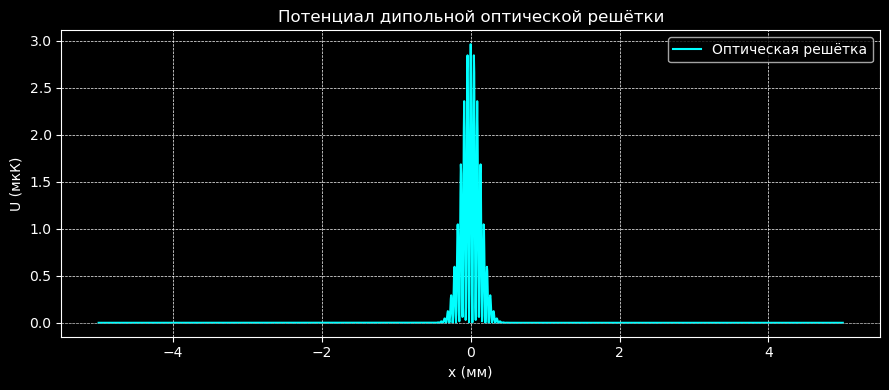

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Константы ---
c = 3e8  # м/с
hbar = 1.0545718e-34  # Дж·с
k_B = 1.38e-23  # Дж/К
lambda_laser = 1012e-9  # м
omega_0 = 2 * np.pi * 296e12
delta = 2 * np.pi * 88e12  # рад/с
Gamma = 2 * np.pi * 3e6  # рад/с
P = 2  # Вт
w_0 = 243e-6  # м
k_laser = 2 * np.pi / lambda_laser

# --- Потенциал ---
def I_lattice(x: float) -> float:
    envelope = np.exp(-2 * x**2 / w_0**2)
    standing_wave = np.cos(k_laser * x)**2
    return (2 * P / (np.pi * w_0**2)) * envelope * standing_wave

def U_lattice(x: float) -> float:
    I = I_lattice(x)
    prefactor = (3 * np.pi * c**2 * Gamma) / (2 * omega_0**3)
    U = prefactor * (1 / delta - 1 / (2 * omega_0 + delta)) * I
    return U / (k_B * 1e-6)  # мкК

# --- Визуализация (опц.) ---
if __name__ == "__main__":
    x_vals = np.linspace(-5e-3, 5e-3, 2000)
    U_vals = [U_lattice(x) for x in x_vals]

    plt.style.use("dark_background")
    plt.figure(figsize=(9, 4))
    plt.plot(x_vals * 1e3, U_vals, color='cyan', label='Оптическая решётка')
    plt.xlabel("x (мм)")
    plt.ylabel("U (мкК)")
    plt.title("Потенциал дипольной оптической решётки")
    plt.axhline(0, color='gray', lw=0.5, ls="--")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()